# LGT4HEP Unit05 Day18



Consider a complex scalar field $\varphi(x)\equiv\rho(x)e^{i\theta(x)}$ in the limit $\lambda\to\infty$, as discussed in class. In this limit the magnitude is frozen $\rho(x)=1$ and the only degree of freedom is $\theta(x)\in[-\pi,\pi]$. The action is

$$
S[\theta]=-2\kappa\sum_z\sum_\mu {\rm Re}\{\exp(-i\theta_{z+\hat\mu})\exp(i\theta_z)\}=
-2\kappa\sum_z\sum_\mu \cos(\theta_z-\theta_{z+\hat\mu})
$$

and the partition function (i.e. the path integral)

$$
Z=\int_{-\pi}^{\pi}\prod_x d\theta_x e^{-S[\theta]}.
$$

The goal of this homework is to build a Markov Chain Monte Carlo process to sample the field configurations (i.e. $\theta_x$) and calculate the following observable:

$$
L_\varphi\equiv\frac{1}{2V}\sum_{\langle xy\rangle}\exp(-i\theta_{x})\exp(i\theta_y)\equiv
\frac{1}{V}\sum_z\sum_\mu {\rm Re}\{\exp(-i\theta_{z+\hat\mu})\exp(i\theta_z)\}\equiv
\frac{1}{V}\sum_z\sum_\mu \cos(\theta_z-\theta_{z+\hat\mu}),
$$

where $V$ is lattice volume (the number of sites).

In this notebook we work on 2D lattice.

## 1. Prerequisites

Load the packages.

In [2]:
import numpy as np
import random
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML


Global parameters: lattice sizes, volume, couplings, global field array. **Note: Start with size $N=4$ or even $N=2$ to speed up the debugging, then increase to $N=6$ once the code is working properly.**

In [3]:
# lattice sizes -- global variables, for simplicity deal with a square lattice
N = 6
Nx = N
Nt = N
# volume measured in sites
Vn = Nx*Nt
# the coupling -- global variable
kappa = 0.1

# global field storage
field_theta = np.zeros( Vn, dtype=float )

# initialize random seed (for reproducibility)
random.seed( 3 )


Here are the functions for mapping lattice integer vector to integer index (i.e. we convert a two-dimensional vector into an integer index that has a value from 0 to ``Nx*Nt-1`` that we used. This is needed because we store the field configuration (array of values of ``theta``) as a one dimensional array, despite that we work on a two-dimensional lattice.

In [4]:
# function to map lattice coordinates to integer index
# input:
# vec - vector of two integer coordinates, x is first, t is second
# output:
# return value - integer index in [0,Nx*Nt) range
def lat_vec_to_index( vec ):
    if len(vec) != 2:
        print( "Error in lat_vec_to_index: only two-dimensional lattices are supported" )
        return -1
    ix = vec[0]
    it = vec[1]
    if ix<0 or ix>=Nx:
        print( "Error in lat_vec_to_index: x coordinate is out of range", ix)
        return -1
    if it<0 or ix>=Nt:
        print( "Error in lat_vec_to_index: t coordinate is out of range", it)
        return -1
    
    return it*Nx + ix

# function to map integer index to integer lattice coordinates
# input:
# i - integer index
# output:
# vec - vector of two integer coordinates, x is first, t is second
def index_to_lat_vec( i, vec ):
    if i<0 or i>=Nx*Nt:
        print( "Error in index_to_lat_vec: integer index is out of range", i )
    if len(vec) != 2:
        print( "Error in index_to_lat_vec: size of x array is not 2", len(vec) )
    it = i // Nx
    ix = i % Nx
    vec[0] = ix
    vec[1] = it


This function generates a random value of angle $\theta$ uniformly distributed in $[-\pi,\pi]$.

In [5]:
# generate random angle in [-pi,pi] uniformly
# return value:
# theta
def get_random_theta():

    # generate new` value of theta uniformly in [-pi,pi]
    r = random.random()
    return ( 2*r - 1 ) * np.pi


The next two function produce two types of field configurations: 1) completely disordered, all values are random, ''hot'' start, 2) completely ordered, all angles set to 0, ''cold'' start.

In [8]:
def make_hot_start( field ):

    for i in range(Vn):
        field[i] = get_random_theta()
        
def make_cold_start( field ):

    for i in range(Vn):
        field[i] = 0


## 2. Auxiliary functions for plotting

In [9]:
# this function generates coordinates for plotting in such a way
# so that each degree of freedom (theta) is plotted as a "magnet",
# half blue, half red line
# input: field configuration
def field_to_lines( field_theta ):
    # blue lines / red lines (even/edd)
    x = []
    y = []
    vec = np.zeros( 2, dtype=int )
    for i in range( Vn ):
        # convert lattice index to vector
        index_to_lat_vec( i, vec )
        dx = alen * np.cos( field_theta[i] )
        dy = alen * np.sin( field_theta[i] )
        x.append( [vec[0],vec[0]+dx] )
        y.append( [vec[1],vec[1]+dy] )
        dx = alen * np.cos( field_theta[i] + np.pi )
        dy = alen * np.sin( field_theta[i] + np.pi )
        x.append( [vec[0],vec[0]+dx] )
        y.append( [vec[1],vec[1]+dy] )
        
    return x,y


# plot the field
def plot_field( field ):
    global alen
    # set figure
    xlim = Nx
    ylim = Nt
    alen = 0.3
    fig = plt.figure()
    fig.set_size_inches(8, 8/Nx*Nt)
    ax = plt.axes( xlim=(-1, xlim), ylim=(-1, ylim) )
    ax.set_aspect( Nt/Nx )
    lines = []
    for i in range( Vn ):
        lobj, = ax.plot([], [], color="blue", lw=2 )
        lines.append( lobj )
        lobj, = ax.plot([], [], color="red", lw=2 )
        lines.append( lobj )

    x, y = field_to_lines( field )
    
    for lnum,line in enumerate(lines):
        line.set_data( x[ lnum ], y[ lnum ] )

    plt.show()


Plot how a ''cold'' starting configuration looks.

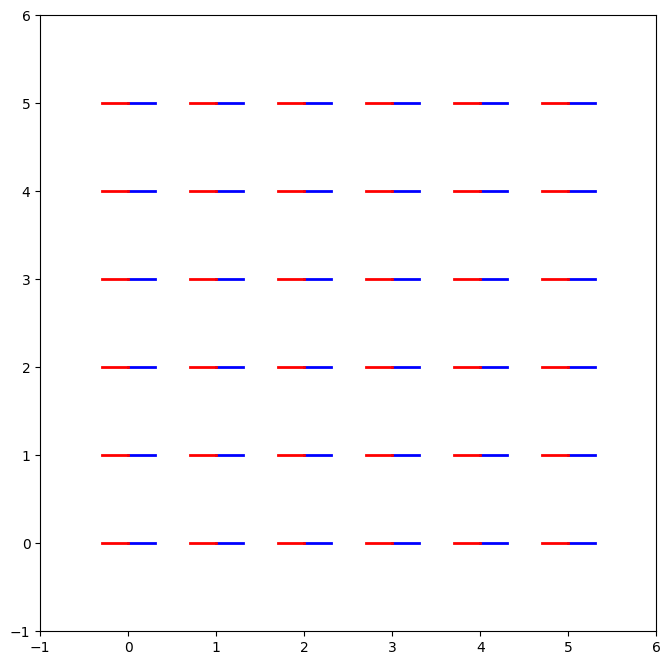

In [10]:
make_cold_start( field_theta )
plot_field( field_theta )


Plot how a ''hot'' starting configuration looks.

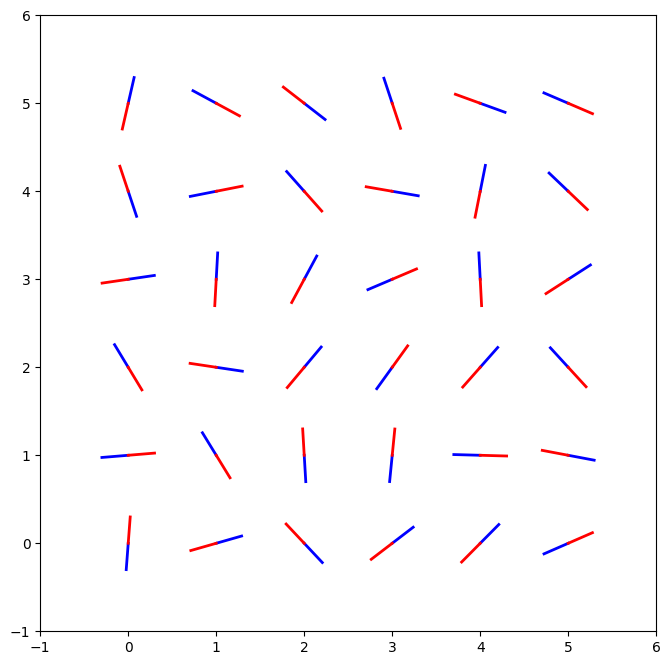

In [11]:
make_hot_start( field_theta )
plot_field( field_theta )


## 3. Auxiliary functions for animation -- works if you have ffmpeg installed

To use this functionality you need properly installed ffmpeg module. This may not work on your platform.

In [ ]:
!pip install ffmpeg

In [12]:
# create animation

# initialization function: set up a subplot for each line
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# animation function -- populate the data for preexisting subplot
def animate(i):
    
    xx, yy = field_to_lines( collected_field[i] ) # note that collected_field is a global variable
    
    for lnum,line in enumerate(lines):
        line.set_data( xx[ lnum ], yy[ lnum ] )
    return lines

# make full animation and export to html
def make_animation():

    global lines
    global alen

    # set figure
    xlim = Nx
    ylim = Nt
    alen = 0.3

    # initialize figure
    fig = plt.figure()
    fig.set_size_inches(8, 8/Nx*Nt)
    # set axis limits and aspect ratio
    ax = plt.axes( xlim=(-1, xlim), ylim=(-1, ylim) )
    ax.set_aspect( Nt/Nx )
    lines = []
    for i in range( Vn ):
        lobj, = ax.plot([], [], color="blue", lw=2 )
        lines.append( lobj )
        lobj, = ax.plot([], [], color="red", lw=2 )
        lines.append( lobj )

    Nframes = len( collected_field ) # note that collected_field is a global variable

    # main animation block, the interval is set in milliseconds
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nframes, interval=500, blit=True, repeat=False)
    # export this animation into a video file, embedded then in HTML
    return anim.to_html5_video()


## 4. Monte Carlo simulation -- random sampling (e.g. kappa=0)

Now we try completely random sampling that corresponds to $\kappa=0$ -- all field configurations are equally likely. The simulation is organized as two nested loops: ``Nsim`` and ``Ninner``. This allows one to record data less often than the number of sweeps. (A _sweep_ is an update where each degree of freedom on the lattice is updated once.)

In [13]:
Nsim = 50 # outer simulation loop where data is recorded, 
          # preferably less than 100, otherwise creating the animation may be slow
Ninner = 1 # inner simulation loop, updates, but data is not recorded
Nequi = 50 # equilibration (no data recorded)

# random start
make_hot_start( field_theta )

# equilibration
for i in range(Nequi):
    for i in range(Vn):
        new_theta = get_random_theta()
        field_theta[i] = new_theta
    
# array to record field configurations for animation
collected_field = []
collected_field.append( field_theta.copy() )

# main production loop
acpt_rate = 0
for i1 in range(Nsim):
    
    for i2 in range(Ninner):
        
        # sweep over the lattice
        for i in range(Vn):
            new_theta = get_random_theta()
            acpt_rate += 1 # record accpetance rate, here all moves are accepted
            field_theta[i] = new_theta
            
    collected_field.append( field_theta.copy() )

# record the acceptance rate
print( "Acceptance rate ", acpt_rate/Vn/Ninner/Nsim*100, " %" )


Acceptance rate  100.0  %


After the simulation the list ``collected_field`` contains ``Nsim`` successive field configuration that we can use to make an animation.

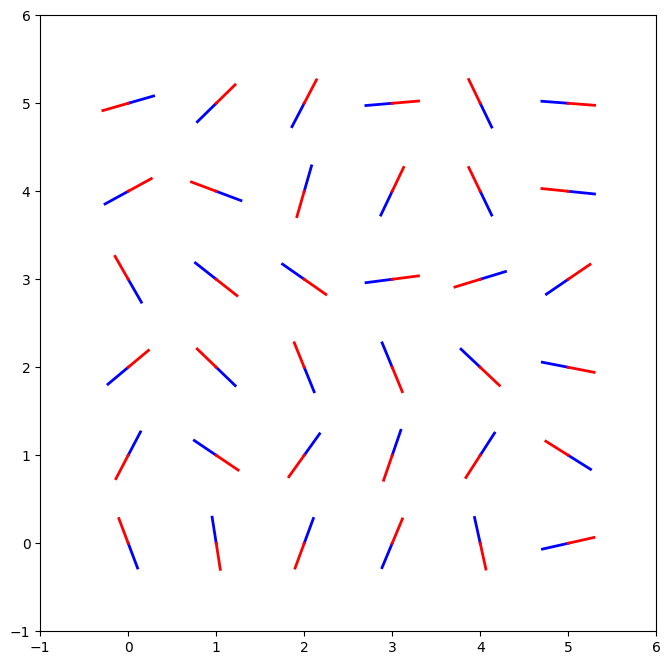

In [14]:
# run animation
from IPython.display import HTML

HTML( make_animation() )

## 5. Forward and backward neighbor indices

To write a program that performs updates with $\kappa>0$ we need to calculate the interaction of $\theta$ being updated with its environment (neighboring sites). For this we need to know the integer indices of the forward and backward neighbors for a given integer index. As an example, here is a function for the forward neighbor index.

In [15]:
# forward neighbor
# input:
# i - integer site index
# mu - direction, 0 for x, 1 for t
# return value:
# j - integer index of the neighbor site
def get_forward_neighbor( i, mu ):
    if mu<0 or mu>1:
        print( "Error in get_forward_neighbor: dir index is out of range", mu )
    vec = np.zeros( 2, dtype=int )
    # convert lattice index to vector
    index_to_lat_vec( i, vec )
    # forward neighbor in mu direction
    vec[mu] = vec[mu] + 1
    # fold into lattice
    vec[0] = vec[0] % Nx
    vec[1] = vec[1] % Nt
    # convert vector to lattice index
    j = lat_vec_to_index( vec )
    return j



We need to test if the function is working properly.

In [16]:
# test forward neighbor index
for i in range(Vn):
    print( get_forward_neighbor(i,0), get_forward_neighbor(i,1) )

1 6
2 7
3 8
4 9
5 10
0 11
7 12
8 13
9 14
10 15
11 16
6 17
13 18
14 19
15 20
16 21
17 22
12 23
19 24
20 25
21 26
22 27
23 28
18 29
25 30
26 31
27 32
28 33
29 34
24 35
31 0
32 1
33 2
34 3
35 4
30 5


**Exercise 1:** Write a function for the backward index. 

In [22]:

# backward neighbor
# input:
# i - integer site index
# mu - direction, 0 for x, 1 for t
# return value:
# j - integer index of the neighbor site
def get_backward_neighbor( i, mu ):
    if mu<0 or mu>1:
        print( "Error in get_forward_neighbor: dir index is out of range", mu )
    vec = np.zeros( 2, dtype=int )
    # convert lattice index to vector
    index_to_lat_vec( i, vec )
    # backward neighbor in mu direction
    # ADD YOUR CODE HERE
    # fold into lattice
    # ADD YOUR CODE HERE    
    # ADD YOUR CODE HERE
    # convert vector to lattice index
    j = lat_vec_to_index( vec )
    return j



**Exercise 2 (5 pts):** Test the backward index function. 

In [15]:
# ADD YOUR CODE HERE

5 30
0 31
1 32
2 33
3 34
4 35
11 0
6 1
7 2
8 3
9 4
10 5
17 6
12 7
13 8
14 9
15 10
16 11
23 12
18 13
19 14
20 15
21 16
22 17
29 18
24 19
25 20
26 21
27 22
28 23
35 24
30 25
31 26
32 27
33 28
34 29


## 6. Calculate environment

Let ``j`` be the index of the site being updated. The ''environment'' is then

$$
S_x\equiv \sum_{\mu=\pm x, \pm t}\exp(i\theta_{j+\hat \mu})
$$

**Exercise 3 (15 pts):** Write a function that given the field array and the index of a site ``i`` returns ``Sx`` (as a complex number). 

In [23]:

# calculate the environment for site i
# input:
# field -- field array of size Vn
# i -- integer site index
# return value:
# Sx -- sum of the neighboring "spins"
def get_environment_theta( field, i ):
    Sx = 0
    # loop on dimensions
    for idir in range(2):
        # index of the forward neighbor
        j = get_forward_neighbor( i, idir )
        # add to the total
        Sx += np.exp( field[j] * 1j )
        # index of the backward neighbor
        j = get_backward_neighbor( i, idir )
        # add to the total
        Sx += np.exp( field[j] * 1j )
    return Sx



## 7. Generate new value of theta with the Metropolis algorithm

Now that we can calculate $S_x$ we can write a function that generates a new value for $\theta$ with the following algorithm:

* Propose $\theta'$ uniformly in $[-\pi,\pi]$.
* Accept with the probability
$$
\min\left\{1,\exp\left[2\kappa{\rm Re}\{S_x^\dagger(\exp(i\theta)-\exp(i\theta')\}\right]\right\},
$$
where $\theta$ is the old value. If accepted, the function should return two values: $\theta'$ and 1, if rejected:
$\theta$ (old value) and 0. The second value will help to count the number of accepted moves.

**Exercise 4 (15 pts):** Write a function to generate new value of $\theta$. 

In [17]:

# Metropolis to generate theta
# input:
# old_theta -- existing value of theta
# Sx -- the environment (as complex number)
# return:
# new_theta, acpt -- new_theta is new angle if accepted, or old_theta otherwise; acpt -- =1 if accepted, =0 otherwise
def get_theta( old_theta, Sx ):
    
    # generate new value of theta uniformly in [-pi,pi]
    new_theta = get_random_theta()
    
    # difference between new and old field
    diff = np.exp( new_theta * 1j ) - np.exp( old_theta * 1j )
    
    # real part of the environment times the field difference
    A = # ADD YOUR CODE HERE
    r = random.random()
    
    # acceptance
    if r < # ADD YOUR CODE HERE: # accept
        return new_theta,1
    else:
        return old_theta,0



## 8. Calculate the action

Our observable is essentially the action itself (in fact, the action density as it is normalized by volume).



**Exercise 5 (10 pts):** Write a function to calcualte $L_\varphi$ defined above. 

In [24]:

# calculate the action density
# input:
# field -- field array of size Vn
# return value:
# action density L_phi
def get_action( field ):
    act = 0
    for i in range(Vn):
        # loop on dimensions
        for idir in range(2):
            # index of the forward neighbor
            j = get_forward_neighbor( i, idir )
            # add to the total
            act += np.cos( field[i] - field[j] )

    # normalize by volume
    act /= Vn

    return act



## 9. Full Monte Carlo simulation

Now we have all the tools to perform actual Monte Carlo simulation for $\kappa>0$.

**Exercise 6 (5 pts):** Use the code below to run the simulation and debug the functions for the environment and the Metropolis algorithm to generate new value of theta. Note that in this block we also record the values of the observable (action density $L_\varphi$) in the ``act_series`` list. 

In [25]:
Nsim = 50 # outer simulation loop where data is recorded, 
          # preferably less than 100, otherwise creating the animation may be slow
Ninner = 1 # inner simulation loop, updates, but data is not recorded
Nequi = 50 # equilibration (no data recorded)

# action time series
act_series = []

# random start
make_hot_start( field_theta )

# equilibration
for i in range(Nequi):
    for i in range(Vn):
        new_theta = get_random_theta()
        field_theta[i] = new_theta
    
# array to record field configurations for animation
collected_field = []
collected_field.append( field_theta.copy() )

# main production loop
acpt_rate = 0
for i1 in range(Nsim):
    
    for i2 in range(Ninner):
        
        # sweep over the lattice
        for i in range(Vn):
            Sx = # ADD YOUR CODE HERE
            new_theta,acpt = # ADD YOUR CODE HERE
            acpt_rate += acpt
            field_theta[i] = new_theta
            
    collected_field.append( field_theta.copy() )
    
    # record action
    act_series.append( get_action( field_theta ) )

# record the acceptance rate
print( "Acceptance rate ", acpt_rate/Vn/Ninner/Nsim*100, " %" )


SyntaxError: invalid syntax (2879749618.py, line 30)

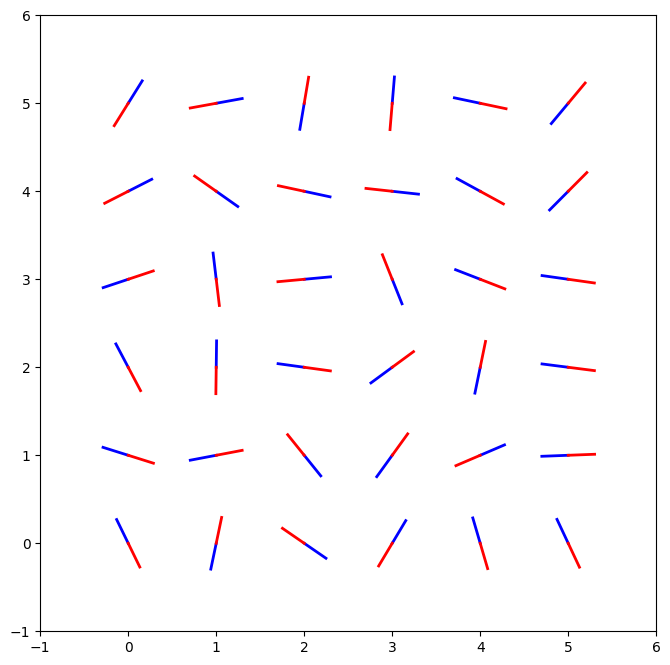

In [21]:
# run animation

HTML(make_animation())

## 10. Data analysis

As a result of the simulation we recorded the time series for the values of the action density. We can extract the mean and the errorbar (using the definition of the unbiased variance).

**Exercise 7 (10 pts):** Write a function to calculate the mean and the errorbar. 

In [28]:

# get mean and errorbar from a time series
# input:
# series -- list with time series
# return value:
# xm, xe -- mean and errorbar
def get_mean_and_error( series ):

    N = len(series)
    xm = 0
    xv = 0
    xe = 0
    for i in range(N):
        xm += series[i]
    xm /= N
    for i in range(N):
        xv += ( series[i] - xm )**2
    xv /= N*(N-1)
    xe = np.sqrt( xv )
    return xm, xe



# 11. Dependence of the action density on $\kappa$

With the code above we can calculate the action density for arbitrary $\kappa>0$. For small values of $\kappa$ we can use the hopping parameter expansion to test the code.

**Exercise 8 (25 pts):** Reuse the code from exercise 6 with proper modifications to perform the simulation for
$\kappa=0,0.05,0.10,0.15,0.20,0.25$ and extract the action density and errorbar for each value of $\kappa$. Plot the action density (with errors) vs $\kappa$ together with the hopping parameter expansion which in this case is:
$$
L_\varphi=2\kappa+3\kappa^3+O(\kappa^5)
$$
Reasonable parameters for $6\times6$ lattice may be ``Nequi=300``, ``Nsim=400``, ``Ninner=20``. However, use smaller values to debug the code and larger values for final production run. Do not store the field configurations
(i.e. do not append to ``collected_field`` list) since animation is not needed here.

In [29]:

# function to run simulation at given parameters
def run_simulation( in_kappa, Nequi, Nsim, Ninner=1 ):

    global kappa
    global field_theta
    global collected_field
    global act_series

    kappa = in_kappa

    # random start
    make_hot_start( field_theta )

    # equilibration
    for iequ in range(Nequi):
        for i in range(Vn):
            Sx = get_environment_theta( field_theta, i )
            new_theta,acpt = get_theta( field_theta[i], Sx )
            field_theta[i] = new_theta
    

    # main production loop
    acpt_rate = 0
    for i1 in range(Nsim):
    
        for i2 in range(Ninner):

            for i in range(Vn):
                Sx = # ADD YOUR CODE HERE
                new_theta,acpt = # ADD YOUR CODE HERE
                acpt_rate += acpt
                field_theta[i] = new_theta

        # record action
        act_series.append( get_action( field_theta ) )

    print( "Acceptance rate ", acpt_rate/Vn/Ninner/Nsim*100, " %" )



SyntaxError: invalid syntax (3313650741.py, line 29)

In [30]:

# run simulation and extract 
akappa = [0,0.05,0.10,0.15,0.20,0.25]
en = []
en_err = []

for ak in akappa:
    print( "kappa = ", ak )
    act_series = []
    run_simulation( ak, 300, 400, 20 )
    am, ae = get_mean_and_error( act_series )
    en.append( am )
    en_err.append( ae )



kappa =  0


NameError: name 'get_theta' is not defined

ValueError: 'x' and 'y' must have the same size

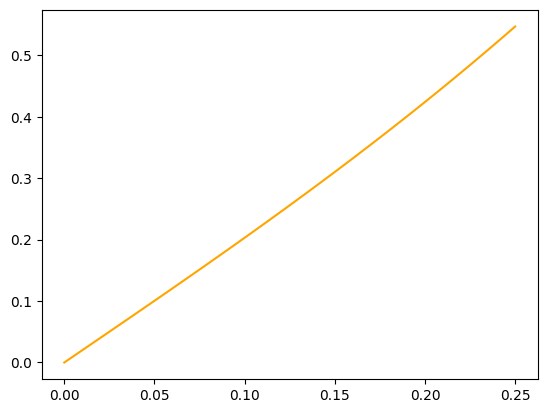

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
# prepare hopping parameter expansion result: 2*k + 3*k^3
xh = np.linspace(0, akappa[-1], num=100, endpoint=True)
yh1 = xh * 2
yh3 = yh1 + xh**3 * 3

# Plotting
plt.plot(xh, yh3, "-", color="orange", label="Hopping parameter expansion")
plt.errorbar(akappa, en, yerr=en_err, fmt="+", color="blue", label=r"Action density $L_\phi$")

# Add legend
plt.legend()

# Display the plot
plt.show()


## 12. Prediction for $\kappa$ beyond the hopping parameter expansion

**Exercise 9 (10 pts):** Once your code is working properly, perform a simulation at $\kappa=2$ and predict the value of the action density with errorbar at this $\kappa$. The autocorrelations are much longer at $\kappa=2$ so you may use ``Nequi=500``, ``Nsim=50``, ``Ninner=200``.

In [28]:

act_series = []
run_simulation( 2.0, 500, 50, 200 )



Acceptance rate  13.053888888888887  %


In [29]:

am, ae = get_mean_and_error( act_series )
print( am, " +/- ", ae)



1.880420881246644  +/-  0.003856996902816158


&#169; Copyright 2024,  Michigan State University Board of Trustees